In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import pickle
sns.set_theme()
rcParams["figure.figsize"] = [20,5] 
warnings.filterwarnings("ignore")

In [62]:
def prepareData():
    data = pd.read_csv("../Other Files/MasterDataset_WithWeatherAndEvent.csv")
    df = data.groupby(["time", "isHoliday"]).agg({"temperature_2m": "median", "relativehumidity_2m": "median", "precipitation": "median", "windspeed_10m": "median", "Duration": "count"}).reset_index()
    df["time"] = df["time"].apply(lambda x: pd.to_datetime(x))
    df = df.sort_values(by="time", ascending=True)
    df = df.rename(columns={"Duration": "rides"})
    df["day"] = df["time"].apply(lambda x: pd.to_datetime(x.strftime("%Y-%m-%d")))
    df["week"] = df["time"].apply(lambda x: x.strftime("%Y-%V"))
    df["month"] = df["time"].apply(lambda x: pd.to_datetime(x.strftime("%Y-%m")))
    df["year"] = df["time"].apply(lambda x: pd.to_datetime(x.strftime("%Y")))
    return df

def sampleData(df):
    hourlyDf = df.groupby("time")["rides"].sum().reset_index().set_index("time")
    dailyDf = df.groupby("day")["rides"].sum().reset_index().rename(columns={"day": "time"}).set_index("time")
    weeklyDf = df.groupby("week")["rides"].sum().reset_index().rename(columns={"week": "time"}).set_index("time")
    monthlyDf = df.groupby("month")["rides"].sum().reset_index().rename(columns={"month": "time"}).set_index("time")
    yearlyDf = df.groupby("year")["rides"].sum().reset_index().rename(columns={"year": "time"}).set_index("time")

    return [hourlyDf, dailyDf, weeklyDf, monthlyDf, yearlyDf]

def plotData(hourlyDf, dailyDf):
    fig, ax = plt.subplots(1,1)
    sns.lineplot(data=hourlyDf, x="time", y="rides", ax=ax, label="Hourly", color="orange")
    ax2=ax.twinx()
    sns.lineplot(data=dailyDf, x="time", y="rides", label="Daily", ax=ax2, color="blue")
    ax.legend(loc="upper left")

def decompose(dataset, period):
    model = "additive"
    result = seasonal_decompose(dataset, model=model, period=period)
    dataset.loc[:,"seasonality"] = result.seasonal
    dataset.loc[:,"trend"] = result.trend
    plot = result.plot()
    return dataset

def testStationarity(dataset):
    result = adfuller(dataset["rides"])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

def testAR(dataset, lags=100):
    acf = plot_acf(dataset["rides"], lags=lags)
    pacf = plot_pacf(dataset["rides"], lags=lags)

def trainModel(df, order, seasonalOrder, trainStart="2015-01-01", trainEnd="2019-01-01"):
    trainData = df[((df.index >= trainStart) & (df.index <= trainEnd))]
    model = SARIMAX(trainData.rides, order=order, seasonal_order=seasonalOrder)
    fit = model.fit(disp=False)
    pred = fit.predict(0, len(trainData)-1)
    trainData.loc[:,"pred"] = pred
    trainData.loc[:,"residuals"] = trainData["rides"] - trainData["pred"]
    mape = round(np.mean(abs(trainData["residuals"]/trainData["rides"])), 4)
    rmse = np.sqrt(np.mean(trainData["residuals"]**2))
    return fit, trainData, mape, rmse

def evaluateTraining(trainData, plotStart=None, plotEnd=None):
    
    fig, ax = plt.subplots(2,1,figsize=(20,10))
    plotData = trainData.copy()
    if plotStart != None:
        plotData = plotData[plotData.index >= plotStart]
    if plotEnd != None:
        plotData = plotData[plotData.index <= plotEnd]

    plotData[["pred", "rides"]].plot(ax=ax[0])
    plotData[["residuals"]].plot(ax=ax[1])
    
    mape = round(np.mean(abs(trainData["residuals"]/trainData["rides"])), 4)
    rmse = np.sqrt(np.mean(trainData["residuals"]**2))

    print(f"MAPE : {mape}")
    print(f"RMSE : {rmse}")

def forecast(df, model, trainData, period):
    trainEnd = list(trainData.index)[-1]
    testData = df[df.index > trainEnd].reset_index().iloc[:period,:]
    pred = model.forecast(period)
    testData.loc[:,"pred"] = pred.values
    testData.loc[:,"residuals"] = testData["rides"] - testData["pred"]
    
    testData[["time", "pred", "rides"]].set_index("time").plot()

    mape = round(np.mean(abs(testData["residuals"]/testData["rides"])), 4)
    rmse = np.sqrt(np.mean(testData["residuals"]**2))

    print(f"MAPE : {mape}")
    print(f"RMSE : {rmse}")

    return testData

In [4]:
df = prepareData()

In [5]:
hourlyDf, dailyDf, weeklyDf, monthlyDf, yearlyDf = sampleData(df)

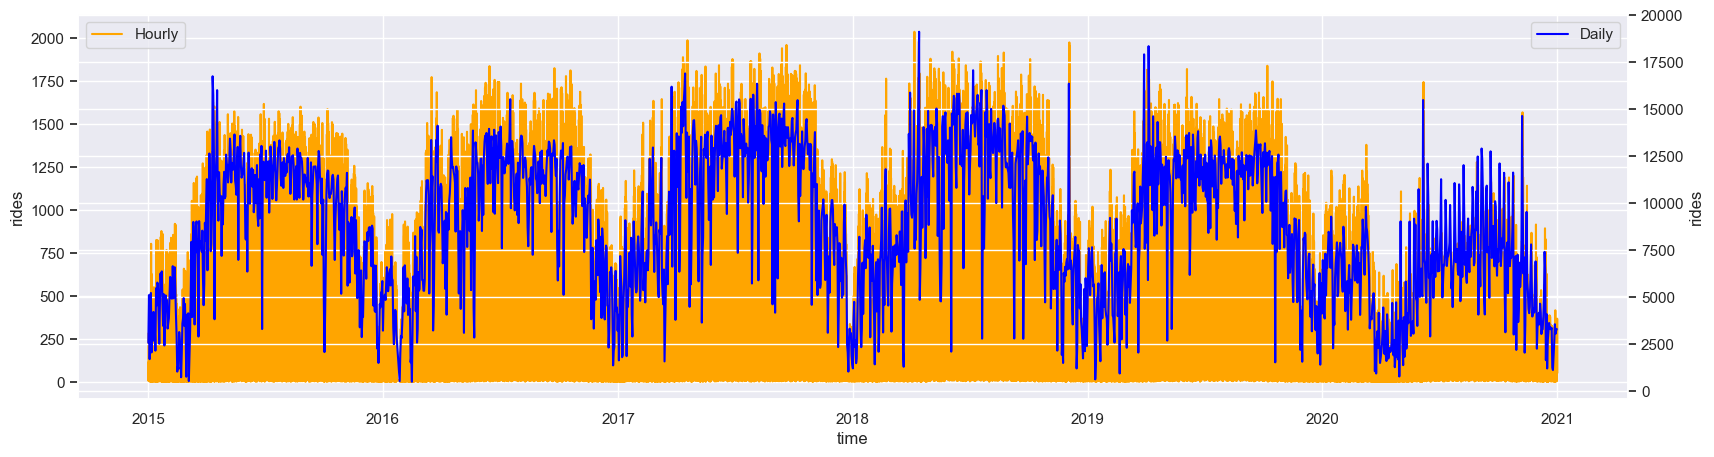

In [63]:
plotData(hourlyDf, dailyDf)

In [ ]:
weee

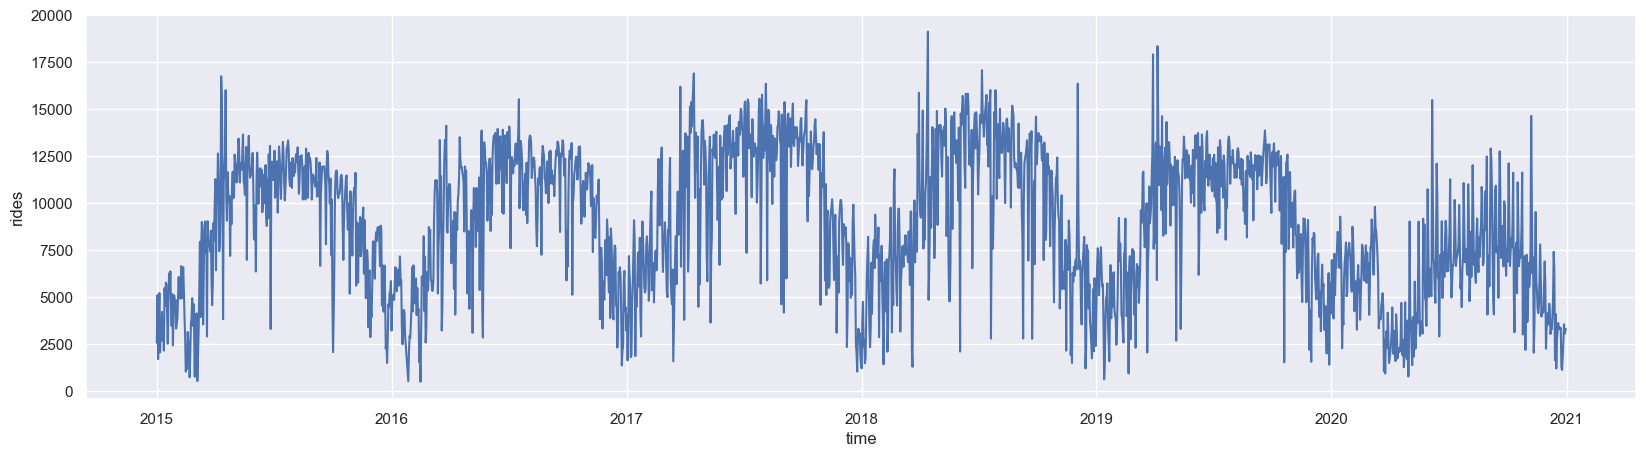

In [33]:
plotData(dailyDf)

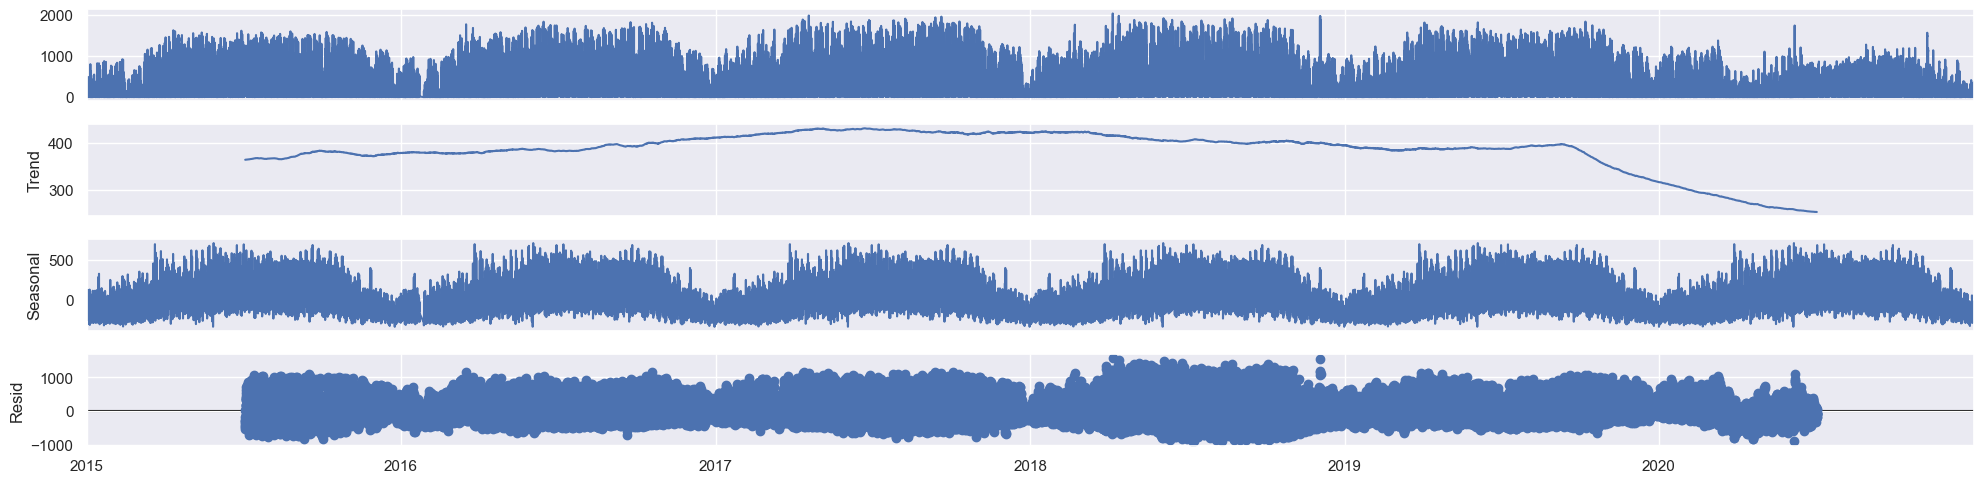

In [6]:
hourlyDf = decompose(hourlyDf, 24*365)

In [7]:
testStationarity(hourlyDf)

ADF Statistic: -12.570608
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


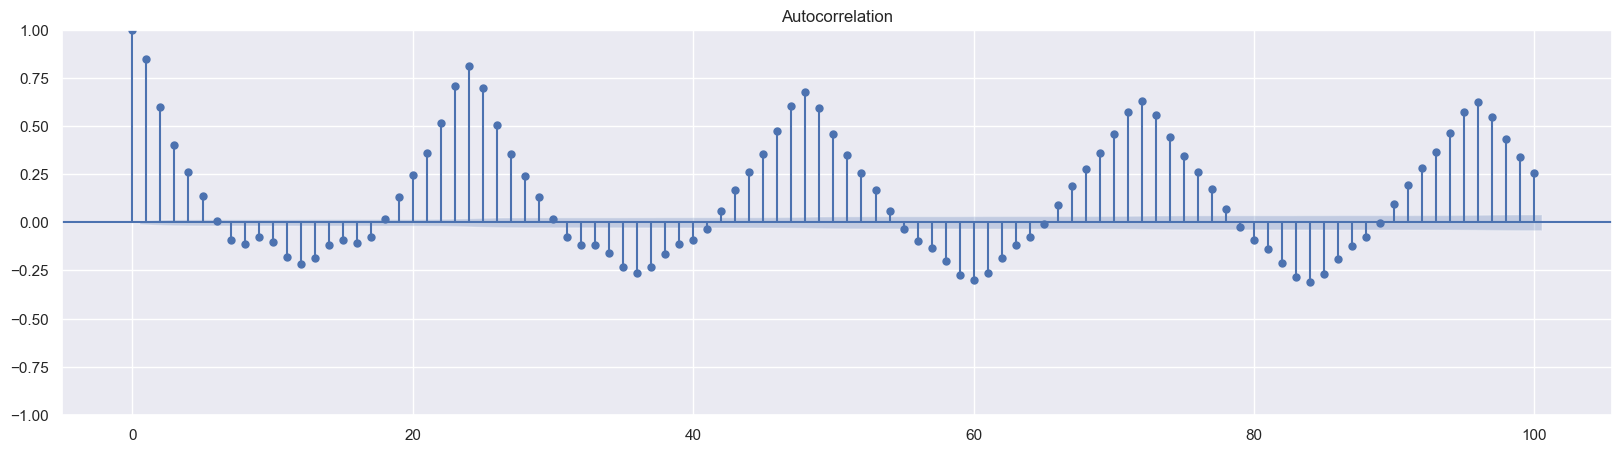

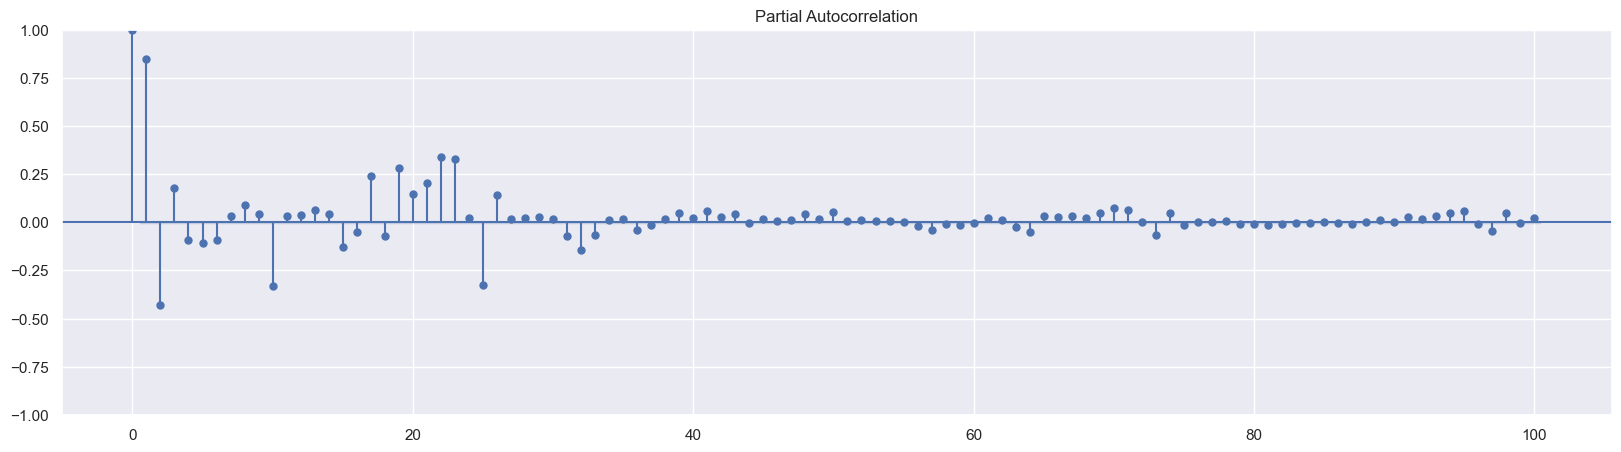

In [8]:
testAR(hourlyDf)

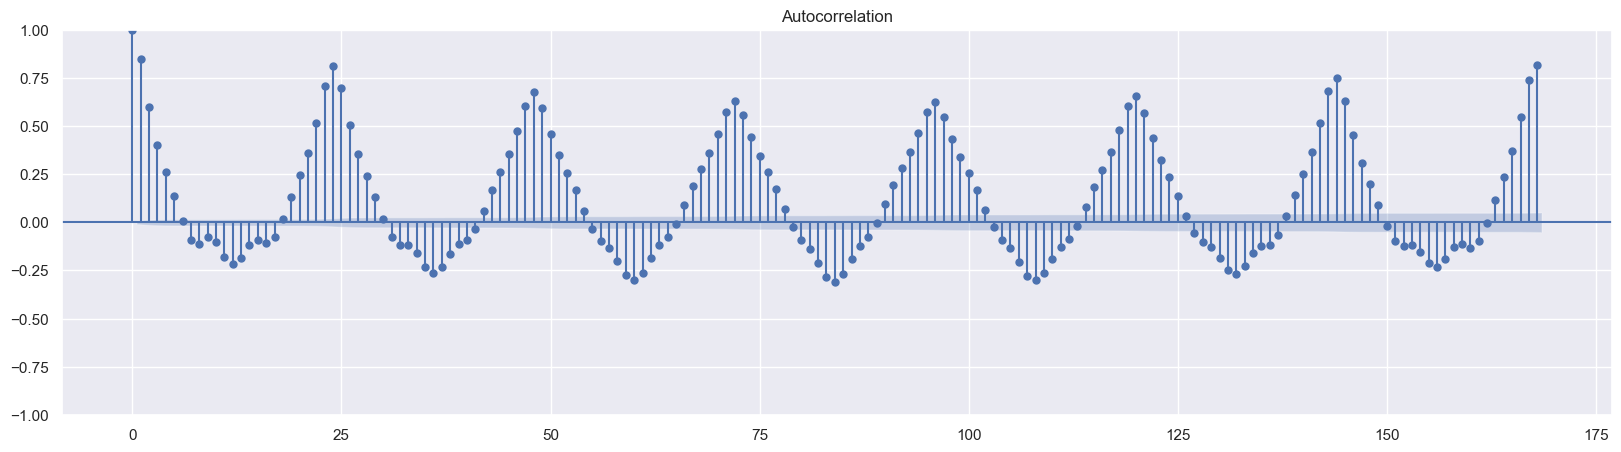

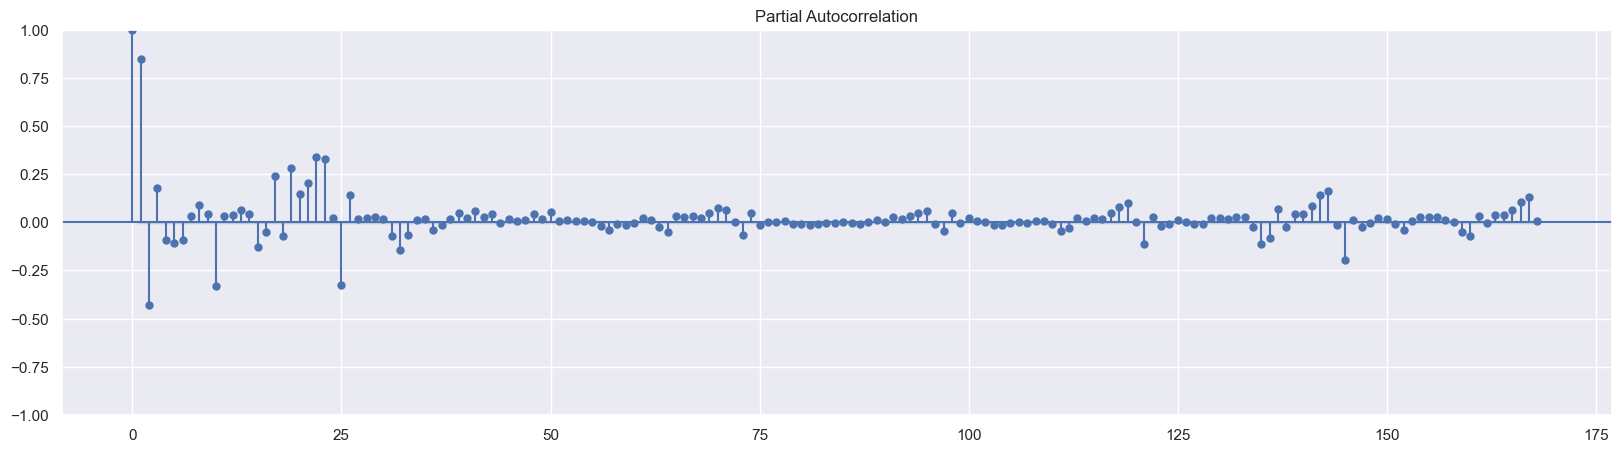

In [9]:
testAR(hourlyDf, 24*7)

In [20]:
TRAINING_RESULT = []
COMBS = []
totalModels = 0
for p in range(1,4):
    for q in range(2,7):
        COMBS.append({"order": (p,0,q), "seasonalOrder": (1,0,0,24)})
        totalModels += 1
for i in range(len(COMBS)):
    print(f"------ Building Model {i+1}/{totalModels} ----------- ")
    order = COMBS[i]["order"]
    seasonalOrder = COMBS[i]["seasonalOrder"]
    model, trainData,  mape, rmse = trainModel(hourlyDf, order, seasonalOrder)
    res = {
        "p": order[0],
        "q": order[2],
        "M": 24,
        "mape": mape,
        "rmse": rmse
    }
    TRAINING_RESULT.append(res)           

------ Building Model 1/15 ----------- 
------ Building Model 2/15 ----------- 
------ Building Model 3/15 ----------- 
------ Building Model 4/15 ----------- 
------ Building Model 5/15 ----------- 
------ Building Model 6/15 ----------- 
------ Building Model 7/15 ----------- 
------ Building Model 8/15 ----------- 
------ Building Model 9/15 ----------- 
------ Building Model 10/15 ----------- 
------ Building Model 11/15 ----------- 
------ Building Model 12/15 ----------- 
------ Building Model 13/15 ----------- 
------ Building Model 14/15 ----------- 
------ Building Model 15/15 ----------- 


In [22]:
pd.DataFrame(TRAINING_RESULT).sort_values(by="mape")

,p,q,M,mape,rmse
0,1,2,24,0.4602,135.038020
1,1,3,24,0.4641,134.967805
11,3,3,24,0.5491,137.306469
5,2,2,24,0.6202,134.060882
10,3,2,24,0.6251,133.815578
13,3,5,24,0.7188,133.958875
6,2,3,24,0.8697,132.379933
4,1,6,24,0.9238,132.259453
12,3,4,24,0.9918,132.247102
3,1,5,24,1.0375,132.731247


In [24]:
p = 1
q = 2
for M in [24*7, 24*30]:
    order = (p,0,q)
    seasonalOrder = (1,0,0,M)
    order = COMBS[i]["order"]
    seasonalOrder = COMBS[i]["seasonalOrder"]
    model, trainData,  mape, rmse = trainModel(hourlyDf, order, seasonalOrder)
    res = {
        "p": order[0],
        "q": order[2],
        "M": 24,
        "mape": mape,
        "rmse": rmse
    }
    TRAINING_RESULT.append(res)

In [30]:
TRAINING_RESULT

[{'p': 1, 'q': 2, 'M': 24, 'mape': 0.4602, 'rmse': 135.03802017774092},
 {'p': 1, 'q': 3, 'M': 24, 'mape': 0.4641, 'rmse': 134.96780456689106},
 {'p': 1, 'q': 4, 'M': 24, 'mape': 1.1043, 'rmse': 133.34564834465752},
 {'p': 1, 'q': 5, 'M': 24, 'mape': 1.0375, 'rmse': 132.73124666434464},
 {'p': 1, 'q': 6, 'M': 24, 'mape': 0.9238, 'rmse': 132.25945290178714},
 {'p': 2, 'q': 2, 'M': 24, 'mape': 0.6202, 'rmse': 134.06088179439163},
 {'p': 2, 'q': 3, 'M': 24, 'mape': 0.8697, 'rmse': 132.3799332760926},
 {'p': 2, 'q': 4, 'M': 24, 'mape': 1.2733, 'rmse': 134.34406252261297},
 {'p': 2, 'q': 5, 'M': 24, 'mape': 1.154, 'rmse': 133.69741439453105},
 {'p': 2, 'q': 6, 'M': 24, 'mape': 1.0632, 'rmse': 132.98631563355696},
 {'p': 3, 'q': 2, 'M': 24, 'mape': 0.6251, 'rmse': 133.81557802402827},
 {'p': 3, 'q': 3, 'M': 24, 'mape': 0.5491, 'rmse': 137.3064685053295},
 {'p': 3, 'q': 4, 'M': 24, 'mape': 0.9918, 'rmse': 132.2471020411867},
 {'p': 3, 'q': 5, 'M': 24, 'mape': 0.7188, 'rmse': 133.9588748227938

MAPE : 0.2722
RMSE : 2195.0325919224174
MAPE : 0.5112
RMSE : 4266.397210488374


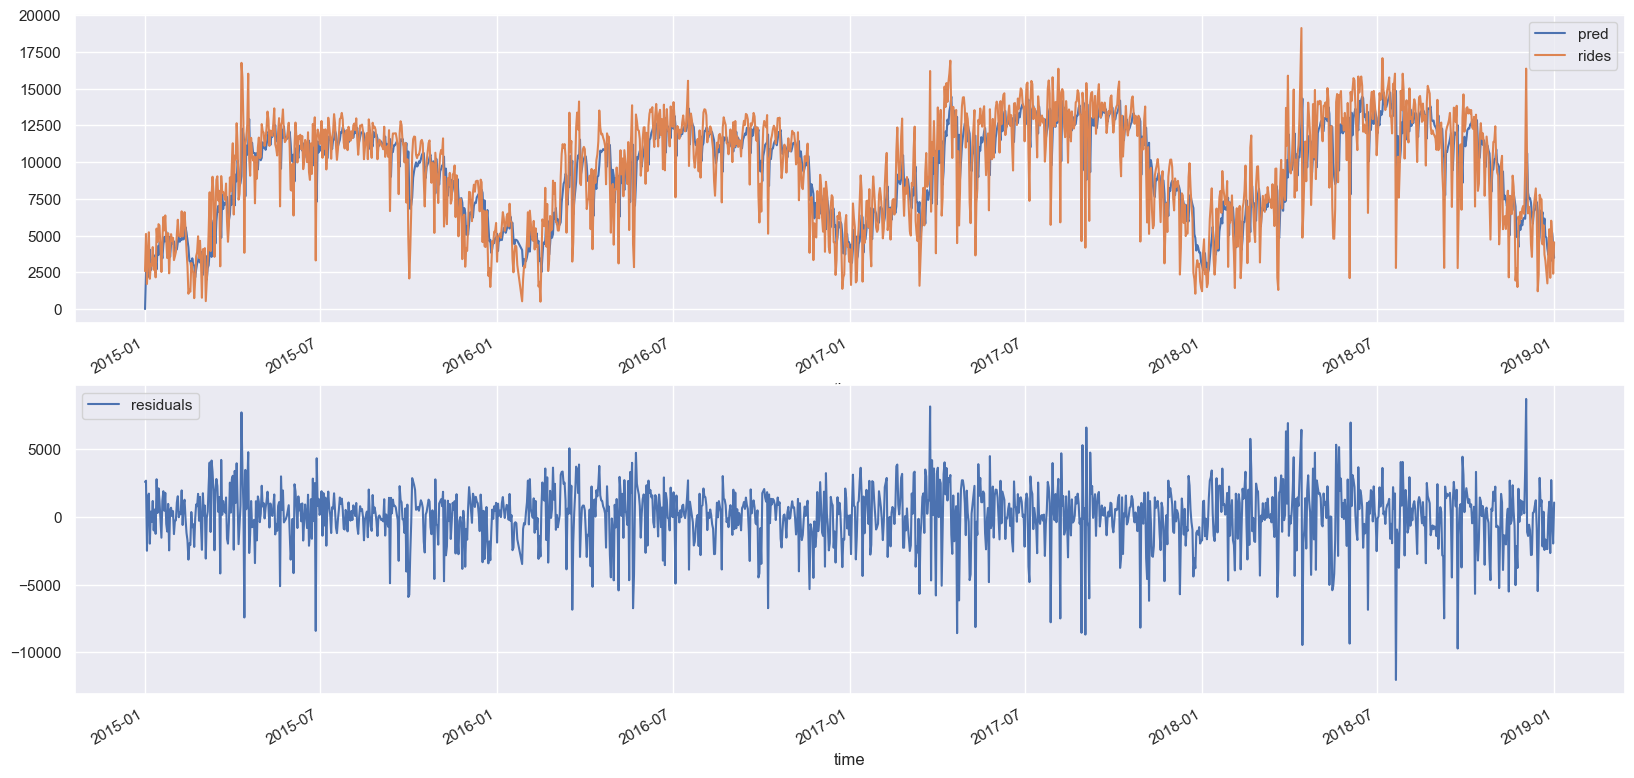

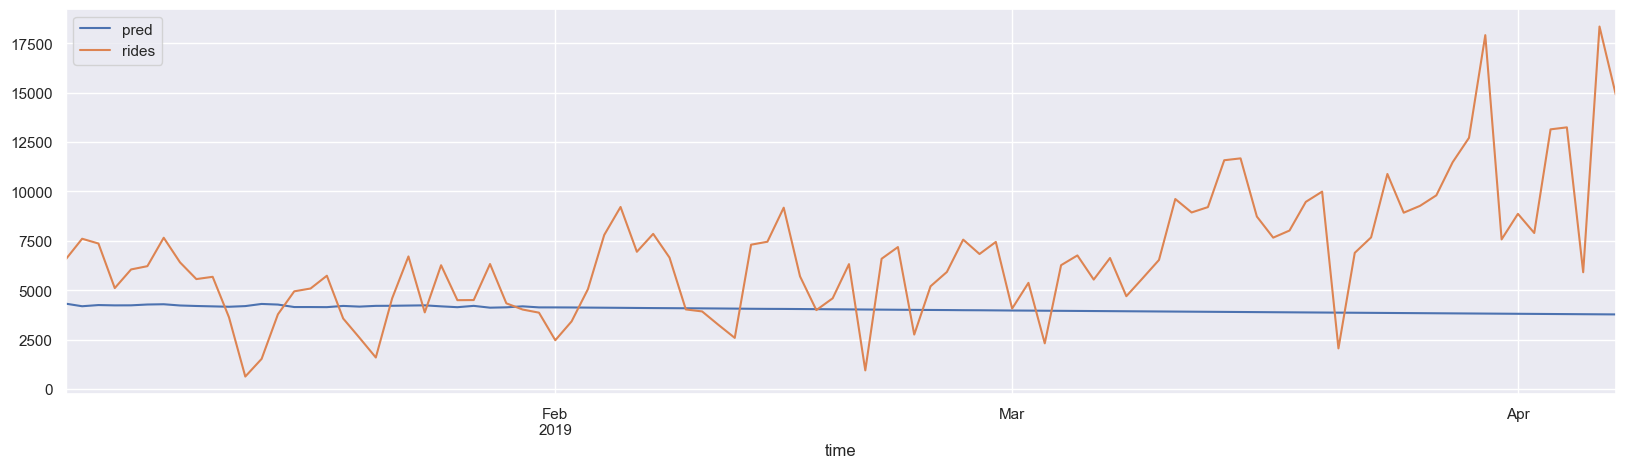

In [67]:
p = 3
q = 7
order = (1,0,2)
seasonalOrder = (1,0,0,30)
model, trainData,  mape, rmse = trainModel(dailyDf, order, seasonalOrder)
evaluateTraining(trainData)
testData = forecast(dailyDf, model, trainData, 24*4)

MAPE : 9.6353
RMSE : 1058.562596620627
MAPE : 77502486.8077
RMSE : 8780606507.187618


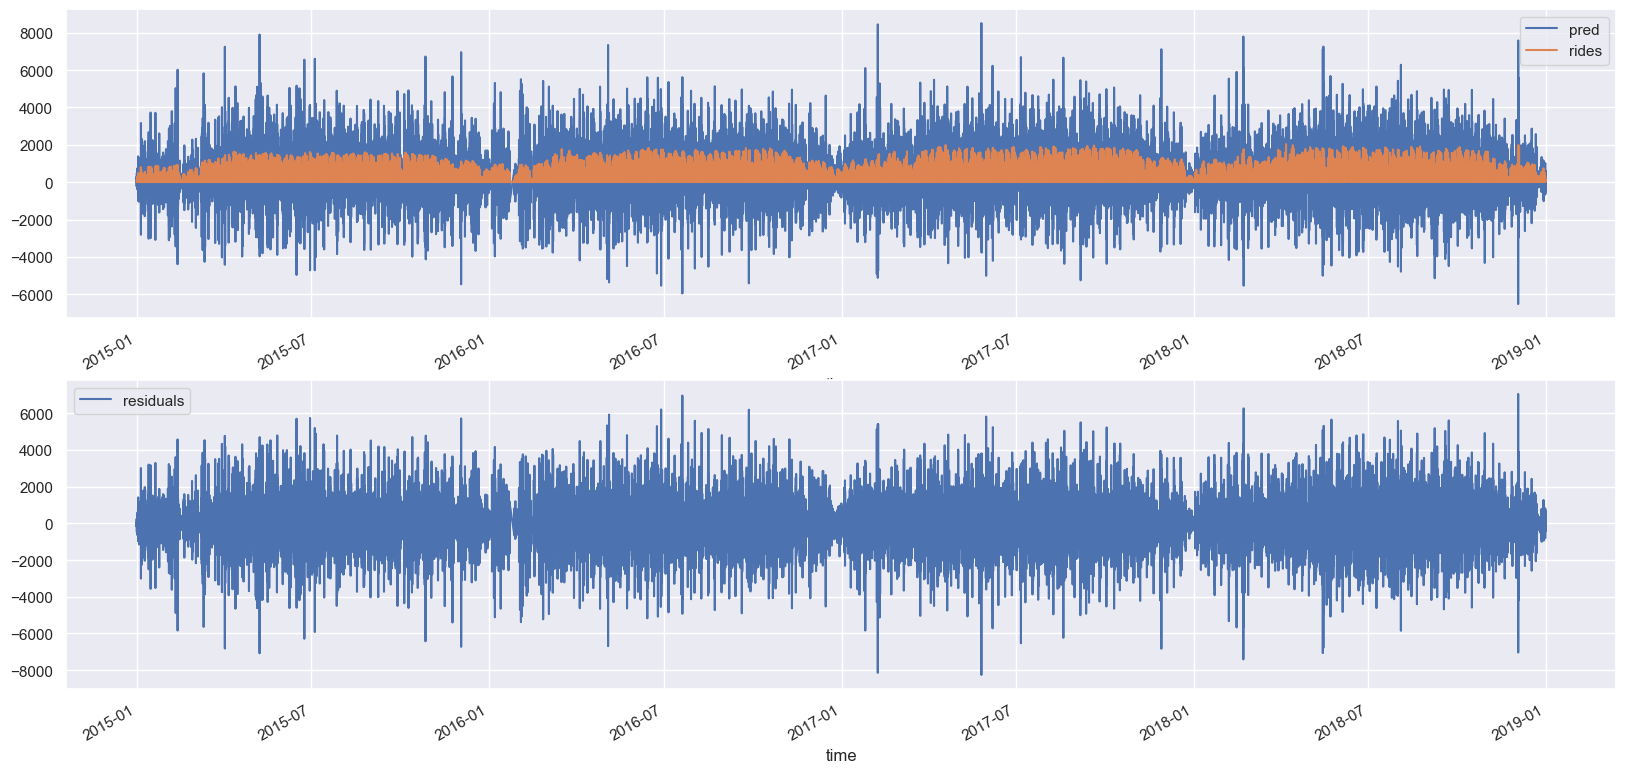

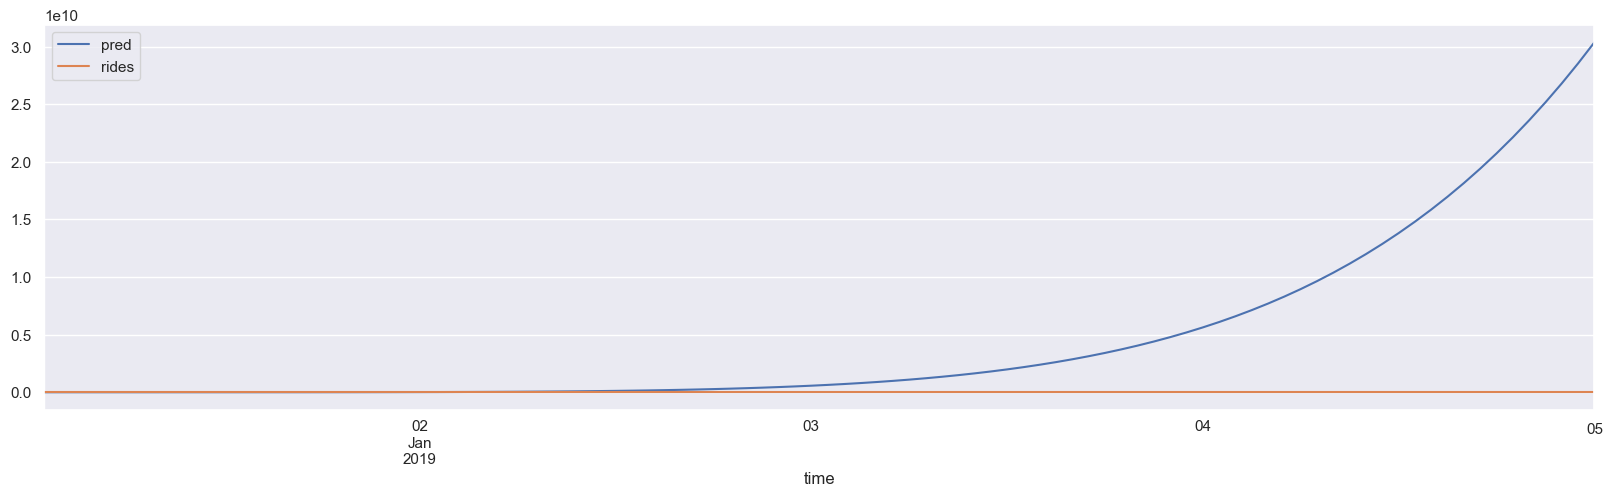

In [13]:
p = 3
q = 7
order = (p,q,0)
seasonalOrder = (1,0,0,24)
model, trainData,  mape, rmse = trainModel(hourlyDf, order, seasonalOrder)
evaluateTraining(trainData)
testData = forecast(hourlyDf, model, trainData, 24*4)

In [16]:
df.rides.describe()

count    52319.000000
mean       371.484394
std        366.258251
min          1.000000
25%         67.000000
50%        272.000000
75%        556.000000
max       2038.000000
Name: rides, dtype: float64